# The basics: bonding descriptors in diamond

In [1]:
%config InlineBackend.figure_format = 'retina'

![The structure of diamond with a single Wannier function plotted](images/structure.png)

This example demonstrates how `pengwann` can be used to calculate the Wannier orbital Hamilton population (WOHP) and the Wannier orbital bond index (WOBI) for the C-C bond in diamond. We will also integrate these descriptors to (roughly speaking) measure the bond strength and bond order.

:::{note}
As referenced in the title above, this example is designed to showcase the **basics** of `pengwann` as applied to a simple system. This should be enough to get you started, but for more information regarding additional functionality and alternative workflows, please see the other [examples](../../examples) and the [API reference](../../api).
:::

## Step 1: Identifying interatomic interactions

Within `pengwann`, the interaction between a given pair of atoms *i* and *j* is the sum total of all interactions between the Wannier functions associated with atom *i* and the Wannier functions associated with atom *j*. In order to compute bonding descriptors for the C-C bond in diamond, we must therefore first figure out which Wannier functions should be assigned to each carbon atom.

In [2]:
from pengwann.geometry import build_geometry

geometry = build_geometry(seedname='wannier90', path='inputs')

print(geometry)

Full Formula (X8 C2)
Reduced Formula: X4C
abc   :   2.517827   2.517827   2.517827
angles:  60.000000  60.000000  60.000000
pbc   :       True       True       True
Sites (10)
  #  SP            a          b          c  wannier_centres
---  ----  ---------  ---------  ---------  -----------------
  0  X0+    0.264244   0.578584  -0.421414  (8,)
  1  X0+    0.171416   0.485756   0.171415  (9,)
  2  X0+   -0.421414   0.264244   0.578584  (8,)
  3  X0+    0.485756   0.171414   0.171414  (9,)
  4  X0+    0.171415   0.171415   0.485756  (9,)
  5  X0+   -0.421415  -0.421415  -0.421414  (8,)
  6  X0+    0.578584  -0.421413   0.264244  (8,)
  7  X0+    0.171413   0.171416   0.171415  (9,)
  8  C      0.5        0.5        0.5       (0, 2, 5, 6)
  9  C      0.25       0.25       0.25      (1, 3, 4, 7)


Above, we have made use of the {py:func}`~pengwann.geometry.build_geometry` function, which parses the Wannier90 seedname_centres.xyz and seedname.win files to extract the coordinates of atoms and Wannier centres as well as the cell vectors. In addition, the `build_geometry` function also assigns Wannier functions to atoms by associated each Wannier centre to its closest atom.

The object returned by `build_geometry` is a {external:class}`~pymatgen.core.structure.Structure` object (from the [pymatgen](https://pymatgen.org/) package), which encapsulates the periodic geometry of the system. The `wannier_centres` column on the right-hand side of the output above details which Wannier centres have been assigned to which atom and vice versa. The numbers represent site indices (with respect to the order of sites/atoms in the `Structure` object itself), for example looking at the last atom in the structure (a carbon atom at site #9), `wannier_centres` => `(1, 3, 4, 7)`, meaning that the Wannier centres at sites #1, #3, #4 and #7 have been assigned to this atom.

:::{warning}
The seedname_centres.xyz file read by the `build_geometry` function should always be generated by Wannier90 with `translate_home cell = false`. If a seedname_centres.xyz file generated with `translated_home_cell = true` is used, then the Wannier centre assignments will still be accurate, but the interatomic interactions (specifically the Bravais lattice vectors associated with the interacting Wannier functions) identified in subsequent steps **may not be accurate**.
:::

Now that we have the geometry of the system and its Wannier centres available to us, we can identify interatomic interactions according to a radial distance cutoff:

In [3]:
from pengwann.geometry import identify_interatomic_interactions

# Find all C-C bonds that are < 1.6 Å.
cutoffs = {('C', 'C'): 1.6}

interactions = identify_interatomic_interactions(geometry, cutoffs)

print(interactions)

Atomic interactions
C8 <=> C9



Sure enough, because we are here using the primitive cell of diamond (which contains only 2 carbon atoms), we find just a single C-C interaction between atoms #8 and #9 (with reference to the `Structure` generated prior).

The object returned by the {py:func}`~pengwann.geometry.identify_interatomic_interactions` function is an {py:class}`~pengwann.interactions.AtomicInteractionContainer`. As the name suggests, this object is designed to collect multiple {py:class}`~pengwann.interactions.AtomicInteraction` objects:

In [4]:
for interaction in interactions:
    print(interaction)

Atomic interaction C8 <=> C9
DOS matrix => Not calculated
WOHP => Not calculated
WOBI => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



As we only have one interaction, iterating over `interactions` just yields one `AtomicInteraction` object. We can also access the interaction between `C8` and `C9` via [numpy](https://numpy.org/)-style indexing:

In [5]:
print(interactions[8, 9])

Atomic interaction C8 <=> C9
DOS matrix => Not calculated
WOHP => Not calculated
WOBI => Not calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



As we can see from the output above, the interaction between `C8` and `C9` is internally represented by the interactions between their respective Wannier functions. The notation used to refer to each Wannier function can be understood as $\ket{w_{iR}} =$ `i[R_1, R_2, R_3]`, where `i` is a band-like index and `R_1`, `R_2` and `R_3` are the components of a Bravais lattice vector.

## Step 2: Building a `DescriptorCalculator`

To actually calculate the WOHP and the WOBI for the C-C bond, we will need to parse a few more Wannier90 input and output files. This can be easily accomplished with the {py:func}`~pengwann.io.read` function, which parses the Wannier90 seedname.eig, seedname_u.mat and seedname_hr.dat files to yield the k-point mesh, the Kohn-Sham eigenvalues, the unitary matrices that define the Wannier functions and the Wannier Hamiltonian:

In [6]:
from pengwann.io import read

kpoints, eigenvalues, u_matrices, hamiltonian = read(seedname='wannier90',
                                                     path='inputs')

### Optional: Obtain the occupation matrix

As we would like to calculate the WOBI as well as the WOHP for the C-C bond, we are also in need of the occupation matrix, which is required to compute elements of the Wannier density matrix. Ideally, the occupation matrix should be read directly from the ab initio code, in our case from VASP. Due to the fact that different ab initio codes output the occupation matrix in different formats, `pengwann` does not provide a generic I/O function for this purpose. We recommend that users look towards larger and more general-use Python packages such as [pymatgen](https://pymatgen.org) or [ase](https://wiki.fysik.dtu.dk/ase/) for this functionality, and use these to read the occupation matrix from their ab initio calculations.

If for whatever reason, the occupation matrix cannot be read directly from the ab initio code, then the {py:class}`~pengwann.occupations.get_occupation_matrix` function can be used to reconstruct it from the Kohn-Sham eigenvalues:

In [7]:
from pengwann.occupations import get_occupation_matrix

mu = 10.5 # The Fermi level
nspin = 2 # The number of electrons per fully-occupied state.

occupation_matrix = get_occupation_matrix(eigenvalues, mu, nspin)

:::{note}
By default, the `get_occupation_matrix` function uses a heaviside function to build the occupation matrix: occupation numbers are 1 below the Fermi level and 0 above it (with a sharp cutoff). In the case of diamond, an insulator, this is perfectly appropriate, but for systems in which thermal smearing has been applied during the ab initio calculation it may be desirable to apply a different occupation function. The `get_occupation_matrix` function has an optional `occupation_function` keyword argument that can be used to apply any arbitary occupation function, several of which are available in the {py:mod}`~pengwann.occupations` module.
:::

---

The actual calculation of bonding descriptors is accomplished in `pengwann` via the {py:class}`~pengwann.descriptors.DescriptorCalculator` class.

In [8]:
from pengwann.descriptors import DescriptorCalculator

num_wann = 8
energy_range = (-15, 25)
resolution = 0.1
sigma = 0.2 # Smearing width

dcalc = DescriptorCalculator.from_eigenvalues(eigenvalues,
                                              num_wann, 
                                              nspin, 
                                              energy_range, 
                                              resolution, 
                                              sigma, 
                                              kpoints, 
                                              u_matrices, 
                                              h=hamiltonian,
                                              occupation_matrix=occupation_matrix)

The `energy_range`, `resolution` and `sigma` arguments all refer to the manner in which the density of states is to be evaluated: from `energy_range[0]` up to `energy_range[1]` in steps of `resolution` smeared by a Gaussian of width `sigma`.

## Step 3: Integrating and plotting the WOHP and the WOBI

Having initialised a `DescriptorCalculator`, actually calculating the WOHP and the WOBI is very straightforward:

In [9]:
interactions = dcalc.assign_descriptors(interactions)

  0%|          | 0/16 [00:00<?, ?it/s]

Note that the {py:meth}`~pengwann.descriptors.DescriptorCalculator.assign_descriptors` method returns a new `AtomicInteractionContainer` rather than updating the original in-place - this behaviour is common throughout the `pengwann` codebase.

In [10]:
print(interactions[8, 9])

Atomic interaction C8 <=> C9
DOS matrix => Calculated
WOHP => Calculated
WOBI => Calculated
IWOHP => Not calculated
IWOBI => Not calculated
Population => Not calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



As seen above, the DOS matrix, the WOHP and the WOBI are now all reported as `Calculated` (the raw `numpy` arrays are not displayed because they would take up an impractical amount of screen real estate in most cases).

To evaluate the IWOHP (integrated WOHP) and the IWOBI (integrated WOBI), we call the {py:meth}`~pengwann.interactions.AtomicInteractionContainer.with_integrals` method:

In [11]:
interactions = interactions.with_integrals(dcalc.energies, mu)

print(interactions[8, 9])

Atomic interaction C8 <=> C9
DOS matrix => Calculated
WOHP => Calculated
WOBI => Calculated
IWOHP => Calculated
IWOBI => Calculated
Population => Calculated
Charge => Not calculated


Associated Wannier interactions
-------------------------------
0[0, 0, 1] <=> 1[0, 0, 0]
0[0, 0, 1] <=> 3[0, 0, 0]
0[0, 0, 1] <=> 4[0, 0, 0]
0[0, 0, 1] <=> 7[0, 0, 0]
2[1, 0, 0] <=> 1[0, 0, 0]
2[1, 0, 0] <=> 3[0, 0, 0]
2[1, 0, 0] <=> 4[0, 0, 0]
2[1, 0, 0] <=> 7[0, 0, 0]
5[1, 1, 1] <=> 1[0, 0, 0]
5[1, 1, 1] <=> 3[0, 0, 0]
5[1, 1, 1] <=> 4[0, 0, 0]
5[1, 1, 1] <=> 7[0, 0, 0]
6[0, 1, 0] <=> 1[0, 0, 0]
6[0, 1, 0] <=> 3[0, 0, 0]
6[0, 1, 0] <=> 4[0, 0, 0]
6[0, 1, 0] <=> 7[0, 0, 0]



:::{note}
The `energies` property of the `DescriptorCalculator` class simply returns the discrete energies at which the DOS and all derived descriptors have been evaluated.
:::

We are now in a position to plot the WOHP and the WOBI:

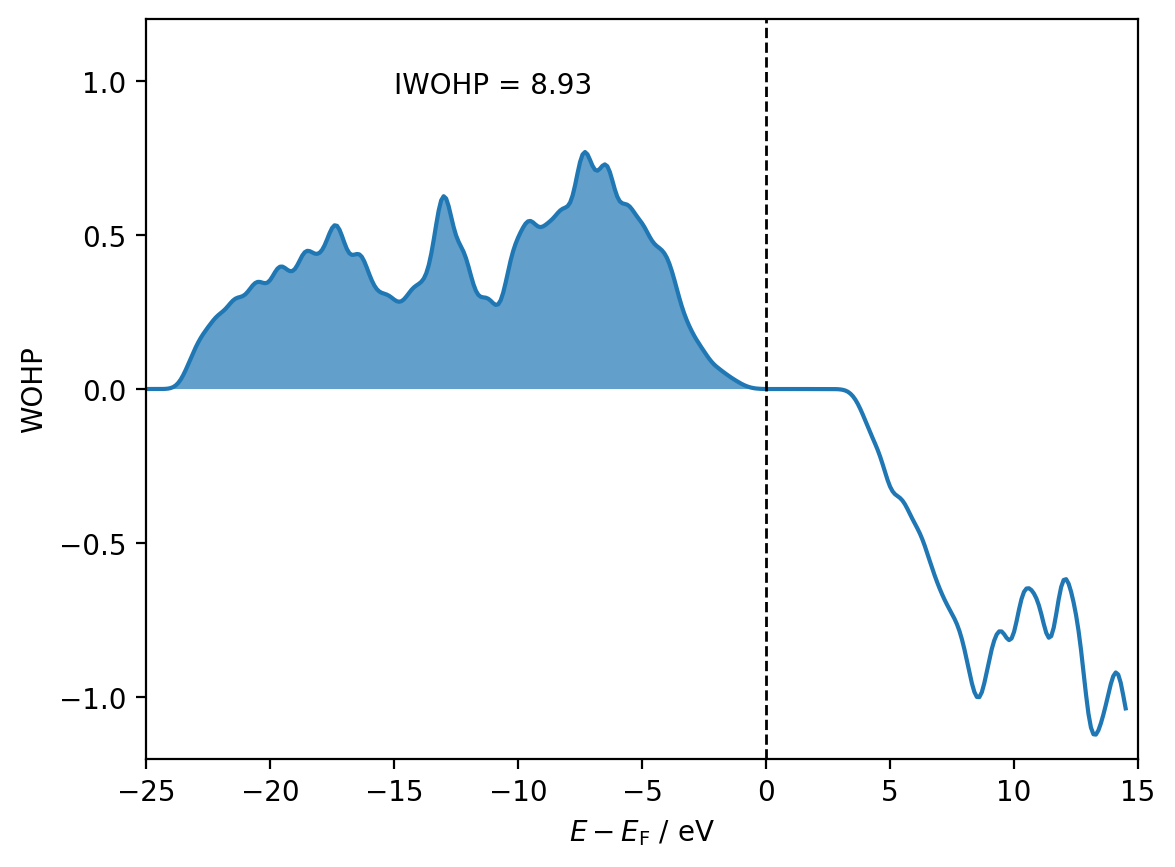

In [12]:
import matplotlib.pyplot as plt

shifted_energies = dcalc.energies - mu

wohp = interactions[8, 9].wohp
iwohp = interactions[8, 9].iwohp

fig, ax = plt.subplots()

ax.plot(shifted_energies, wohp)
ax.fill_between(shifted_energies, wohp, alpha=0.7, where=shifted_energies <= 0)
ax.axvline(x=0, color='black', ls='--', lw=1)

ax.annotate(f'IWOHP = {iwohp:.2f}', (0.25, 0.90), xycoords='axes fraction')

ax.set_xlim(-25, 15)
ax.set_ylim(-1.2, 1.2)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('WOHP')

plt.show()

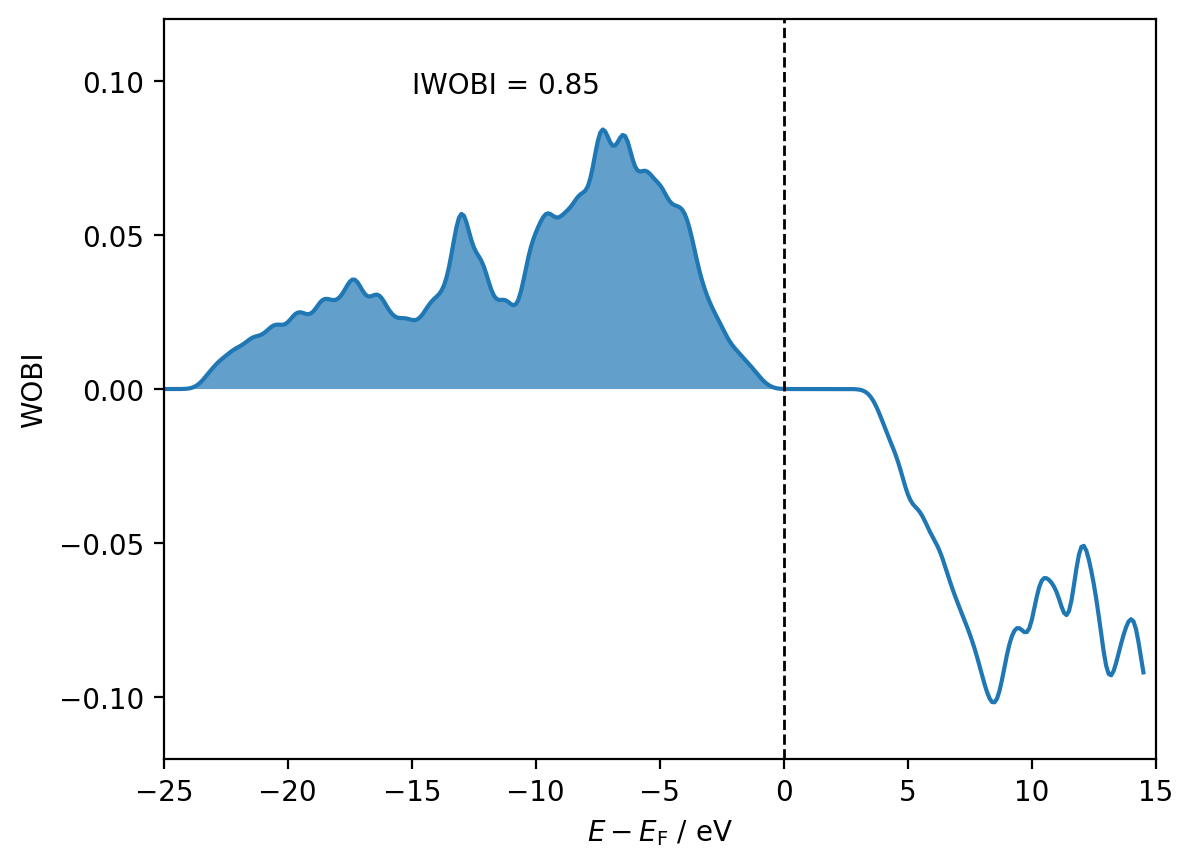

In [13]:
wobi = interactions[8, 9].wobi
iwobi = interactions[8, 9].iwobi

fig, ax = plt.subplots()

ax.plot(shifted_energies, wobi)
ax.fill_between(shifted_energies, wobi, alpha=0.7, where=shifted_energies <= 0)
ax.axvline(x=0, color='black', ls='--', lw=1)

ax.annotate(f'IWOBI = {iwobi:.2f}', (0.25, 0.90), xycoords='axes fraction')

ax.set_xlim(-25, 15)
ax.set_ylim(-0.12, 0.12)

ax.set_xlabel(r'$E - E_{\mathrm{F}}$ / eV')
ax.set_ylabel('WOBI')

plt.show()